# Error Supression Test with Trotterization
This experiment showcases the error suppression and mitigation at the quantum level built into the Qiskit Runtime from:

https://qiskit.org/ecosystem/ibm-runtime/tutorials/Error-Suppression-and-Error-Mitigation.html

In [1]:
# https://qiskit.org/ecosystem/ibm-runtime/tutorials/Error-Suppression-and-Error-Mitigation.html
import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from qiskit.providers.fake_provider import *

plt.rcParams.update({"text.usetex": True})
plt.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams["figure.dpi"] = 200

from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options
#from qiskit_ibm_runtime import (QiskitRuntimeService,Session,Options,Estimator as RuntimeEstimator)

from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit

service = QiskitRuntimeService(channel='ibm_quantum', instance='ibm-q/open/main')


In [2]:
backend_simulator = "ibmq_qasm_simulator" #"simulator_statevector" #
backend = FakeGuadalupe()  #"ibmq_montreal"

qubits = 4
trotter_layer = QuantumCircuit(qubits)
trotter_layer.rx(0.1, range(qubits))
trotter_layer.cx(0, 1)
trotter_layer.cx(2, 3)
trotter_layer.rz(-0.2, [1, 3])
trotter_layer.cx(0, 1)
trotter_layer.cx(2, 3)
trotter_layer.cx(1, 2)
trotter_layer.rz(-0.2, 2)
trotter_layer.cx(1, 2)

num_steps = 6
trotter_circuit_list = []
for i in range(1, num_steps):
    trotter_circuit = QuantumCircuit(qubits)
    for _ in range(i):
        trotter_circuit = trotter_circuit.compose(trotter_layer)
    trotter_circuit_list.append(trotter_circuit)
    #print(f"Trotter circuit with {i} Trotter steps")
    #display(trotter_circuit.draw(fold=-1))

obs = SparsePauliOp("Z" * qubits)
obs_list = [obs] * len(trotter_circuit_list)

In [3]:
# sim run
options = Options()
options.execution.shots = 1024
options.optimization_level = 0  # No optimization
options.resilience_level = 0  # No mitigation

with Session(service=service, backend=backend_simulator) as session:
    estimator_sim = Estimator(session=session, options=options)
    job_sim = estimator_sim.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job_sim.job_id)
    #print(job_sim.result())
    

expvals_ideal = job_sim.result().values
expvals_ideal_variance = [
    metadata["variance"] / metadata["shots"] for metadata in job_sim.result().metadata
]
std_error_ideal = np.sqrt(expvals_ideal_variance)


job id: cimlj0jc243ejrjbf0e0


In [4]:
# Unmitigated, Fake backend
from qiskit.primitives import BackendEstimator

options = Options()
options.execution.shots = 1024
options.optimization_level = 0  # No optimization
options.resilience_level = 0  # No error mitigation

with Session(service=service, backend=backend) as session:
    #estimator = RuntimeEstimator(session=session, options=options)
    estimator = BackendEstimator(backend=backend) #, options=options)
    job = estimator.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job.job_id)
    #print(job.result())

expvals_unmit = job.result().values
expvals_unmit_variance = [
    metadata["variance"] / metadata["shots"] for metadata in job.result().metadata
]
std_error_unmit = np.sqrt(expvals_unmit_variance)

job id: <bound method JobV1.job_id of <qiskit.primitives.primitive_job.PrimitiveJob object at 0x000000003A8FF490>>


We altered the experiment to include the intensity filtering technique with the results shown in the figure. Our technique outperforms T-Rex and ZNE by a wide margin, and arguably does better than PEC (bottom of figure 7). It should be noted that, although PEC performs the best among the quantum resilience techniques, it has a sampling overhead time complexity in the exponential level to the number of gates. 

In [5]:
# Contrast filter
from custom_backend_estimator import CustomBackendEstimator

options     = {'in_range':(0.02, 0.98)}

estimator   = CustomBackendEstimator(backend=backend, options=options)
job_if      = estimator.run(circuits=trotter_circuit_list, observables=obs_list)

print("job id:", job.job_id)
#print(job.result())

expvals_unmit_if = job_if.result().values
expvals_unmit_if_variance = [
    metadata["variance"] / metadata["shots"] for metadata in job_if.result().metadata
]
std_error_if = np.sqrt(expvals_unmit_if_variance)

job id: <bound method JobV1.job_id of <qiskit.primitives.primitive_job.PrimitiveJob object at 0x000000003A8FF490>>


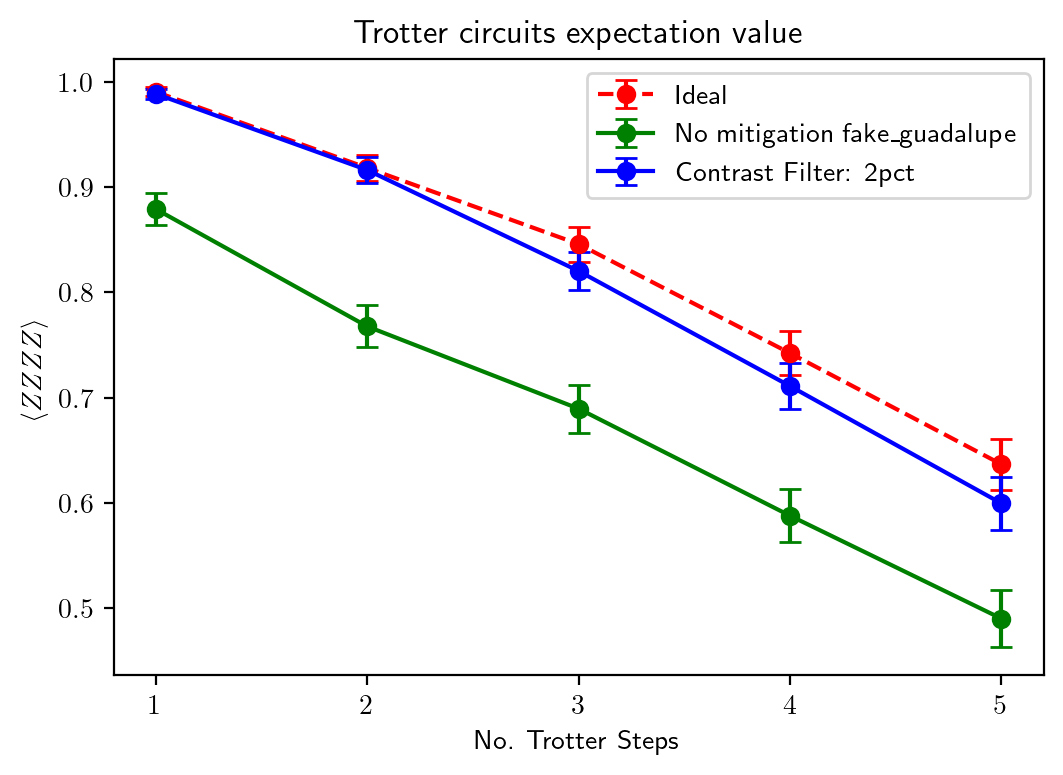

In [6]:
# Plot Results
plt.title("Trotter circuits expectation value")
plt.errorbar(
    range(1, num_steps),
    expvals_ideal,
    std_error_ideal,
    fmt="o",
    linestyle="--",
    capsize=4,
    c="red",
    label="Ideal",
)
plt.errorbar(
    range(1, num_steps),
    expvals_unmit,
    std_error_unmit,
    fmt="o",
    linestyle="-",
    capsize=4,
    c="green",
    label="No mitigation " + str(backend),
)

plt.errorbar(
    range(1, num_steps),
    expvals_unmit_if,
    std_error_if,
    fmt="o",
    linestyle="-",
    capsize=4,
    c="blue",
    label='Contrast Filter: 2pct',
)
plt.ylabel(f"$\langle ZZZZ \\rangle$")
plt.xlabel("No. Trotter Steps")
plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.show()